<a href="https://colab.research.google.com/github/BADS7604Group03/assignment3/blob/main/Project3_Sequencial(GRU200_Modify).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

Check GPU 

In [57]:
# List all NVIDIA GPUs as available in this computer (or Colab's session)
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



Check enviroment

In [58]:
import sys
print(f'Python {sys.version}\n')

import numpy as np
print(f'NumPy {np.__version__}\n')

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print(f'TensorFlow {tf.__version__}')
print(f'tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}')

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print(f'TensorFlow detected {len(gpus)} GPU(s):')
for i, gpu in enumerate(gpus):
  print(f'....GPU No. {i}: Name = {gpu.name}, Type = {gpu.device_type}')

import os
import math
import time
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_error

# Set fixed seeding values for reproducability during experiments
# To guarantee reproducability, make sure that seed values for ANY randomize operation are all set
np.random.seed(1234)
tf.random.set_seed(5678)

Python 3.7.13 (default, Mar 16 2022, 17:37:17) 
[GCC 7.5.0]

NumPy 1.21.5

TensorFlow 2.8.0
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 0 GPU(s):


Prepare relate Library 

In [59]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.models import Sequential
from sklearn import preprocessing
from keras.layers import Conv1D,Flatten,MaxPooling1D,Dropout,TimeDistributed,MaxPool2D,GRU
from keras.layers import Dense,GlobalAveragePooling2D
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn import preprocessing

# Define Functions

In [60]:
def split(x_array, y_array, ratio_train=0.8, ratio_test=0.1):
  n_data = x_array.shape[0]
  n_train = int(n_data * ratio_train)
  n_test = int(n_data *ratio_test)
  n_val = n_data -n_train -n_test
  x_train, y_train = x_array[:n_train], y_array[:n_train]
  x_val, y_val = x_array[n_train:n_train+n_val], y_array[n_train:n_train+n_val]
  x_test, y_test = x_array[n_train+n_val:], y_array[n_train+n_val:]
  return x_train, x_val, x_test, y_train, y_val, y_test

# Load Data

In [61]:
#mount my google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
path = "/content/drive/MyDrive/Colab Notebooks/BADS7604/BADS7604_DL/Project3/BCH OHLC 10Y.xlsx"
df_trans = pd.read_excel(path,sheet_name='Daily')
df_trans.shape

(2469, 6)

In [63]:
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2469 entries, 0 to 2468
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    2469 non-null   datetime64[ns]
 1   Last Price              2469 non-null   float64       
 2   Open Price              2469 non-null   float64       
 3   High Price              2469 non-null   float64       
 4   Low Price               2469 non-null   float64       
 5   BCH TB Equity - Volume  2469 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 115.9 KB


In [64]:
df_trans = df_trans.sort_values(by='Date', ascending=True)
df_trans.head(1)

,Date,Last Price,Open Price,High Price,Low Price,BCH TB Equity - Volume
2468,2012-02-09,5.6,5.64,5.64,5.6,4118750


In [65]:
df_trans.describe(include='all',datetime_is_numeric=True)

,Date,Last Price,Open Price,High Price,Low Price,BCH TB Equity - Volume
count,2469,2469.000000,2469.000000,2469.000000,2469.000000,2.469000e+03
mean,2017-02-27 01:08:14.289185792,12.585439,12.593718,12.770543,12.416541,1.050543e+07
min,2012-02-09 00:00:00,5.360000,5.360000,5.440000,5.360000,1.911000e+05
25%,2014-08-20 00:00:00,7.900000,7.900000,8.080000,7.800000,3.712100e+06
50%,2017-02-28 00:00:00,13.100000,13.100000,13.300000,13.000000,7.320945e+06
75%,2019-09-06 00:00:00,16.100000,16.100000,16.300000,15.900000,1.296720e+07
max,2022-03-23 00:00:00,26.250000,26.500000,26.750000,25.750000,1.416106e+08
std,NaN,4.681297,4.688040,4.752978,4.615918,1.151587e+07


In [66]:
df_last_price = df_trans[["Date","Last Price"]]
df_last_price.shape

(2469, 2)

In [67]:
df_trans.head()

,Date,Last Price,Open Price,High Price,Low Price,BCH TB Equity - Volume
2468,2012-02-09,5.60,5.64,5.64,5.60,4118750
2467,2012-02-10,5.64,5.56,5.64,5.52,6783500
2466,2012-02-13,5.56,5.64,5.64,5.56,1923000
2465,2012-02-14,5.48,5.60,5.60,5.44,3553750
2464,2012-02-15,5.52,5.48,5.56,5.48,2479125


In [68]:
window_size = 20
week = 5
X = []
Y = []

In [69]:
print(range(0 , len(df_trans) - window_size -1 , 1))

range(0, 2448)


In [70]:
window_size = 20
lst_x = []
lst_y = []
val = df_trans['Last Price'].values
for i in range(0,len(val) - window_size -1,1):
  first_price = val[i]
  lst_x.append((val[i+1:i+window_size]-first_price)/first_price)
  lst_y.append((val[i+window_size]-first_price)/first_price)



X = np.array(lst_x).reshape(-1,window_size-1)
Y = np.array(lst_y).reshape(-1,1)

In [71]:
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(np.array(X).reshape(-1,1))
Y_scaled = min_max_scaler.fit_transform(np.array(Y).reshape(-1,1))

In [72]:
arow = len(X)
acol = len(X[0])
print("Rows : " + str(arow))
print("Columns : " + str(acol))

Rows : 2448
Columns : 19


In [73]:
arow = len(Y)
acol = len(Y[0])
print("Rows : " + str(arow))
print("Columns : " + str(acol))

Rows : 2448
Columns : 1


In [74]:
x_train, x_val, x_test, y_train, y_val, y_test = split(X, Y, 0.8, 0.1)
print(len(x_train))
print(len(x_test))
print(len(x_val))

1958
244
246


In [75]:
# train_X,test_X,train_label,test_label = train_test_split(X, Y, test_size=0.1,shuffle=False,random_state=1)
len_t = len(x_train)

In [76]:
train_X = np.array(x_train)
test_X = np.array(x_test)
train_label = np.array(y_train)
test_label = np.array(y_test)
train_val = np.array(x_val)
test_val = np.array(y_val)

In [77]:
train_X = train_X.reshape(train_X.shape[0],1,window_size-1,1)
test_X = test_X.reshape(test_X.shape[0],1,window_size-1,1)
train_val = train_val.reshape(train_val.shape[0],1,window_size-1,1)

# Run model

In [78]:
model = Sequential()

model.add(tf.keras.layers.GRU(200, return_sequences=True, input_shape=(1,19), activation='relu'))
model.add(tf.keras.layers.GRU(200,activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='relu'))
model.add(Dropout(0.3))
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.0001),loss='mse')
print(model.summary())



Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_24 (GRU)                (None, 1, 200)            132600    
                                                                 
 gru_25 (GRU)                (None, 200)               241200    
                                                                 
 dense_16 (Dense)            (None, 1)                 201       
                                                                 
 dropout_7 (Dropout)         (None, 1)                 0         
                                                                 
Total params: 374,001
Trainable params: 374,001
Non-trainable params: 0
_________________________________________________________________
None


In [79]:
model.fit(train_X, train_label, validation_data=(train_val,test_val), epochs=30,batch_size=64,shuffle =False)

Epoch 1/30
31/31 [==============================] - 5s 28ms/step - loss: 0.0063 - val_loss: 0.0066
Epoch 2/30
31/31 [==============================] - 0s 16ms/step - loss: 0.0053 - val_loss: 0.0058
Epoch 3/30
31/31 [==============================] - 0s 16ms/step - loss: 0.0048 - val_loss: 0.0054
Epoch 4/30
31/31 [==============================] - 1s 16ms/step - loss: 0.0046 - val_loss: 0.0051
Epoch 5/30
31/31 [==============================] - 1s 17ms/step - loss: 0.0044 - val_loss: 0.0049
Epoch 6/30
31/31 [==============================] - 0s 16ms/step - loss: 0.0039 - val_loss: 0.0048
Epoch 7/30
31/31 [==============================] - 1s 16ms/step - loss: 0.0041 - val_loss: 0.0047
Epoch 8/30
31/31 [==============================] - 1s 16ms/step - loss: 0.0040 - val_loss: 0.0047
Epoch 9/30
31/31 [==============================] - 1s 17ms/step - loss: 0.0039 - val_loss: 0.0046
Epoch 10/30
31/31 [==============================] - 0s 16ms/step - loss: 0.0039 - val_loss: 0.0046
Epoch 11/

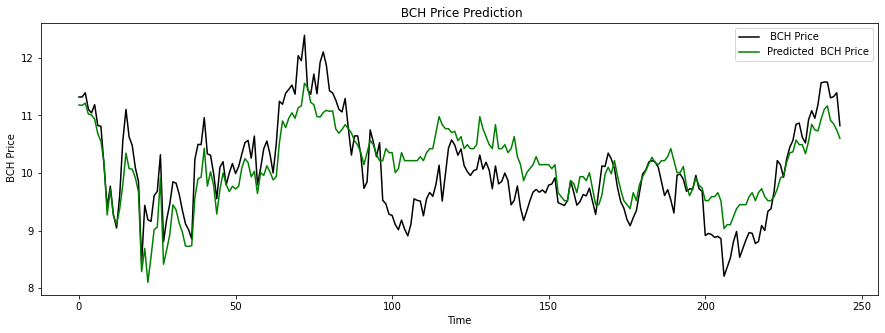

In [80]:
# model.summary()
predicted  = model.predict(test_X)
predicted = min_max_scaler.inverse_transform(predicted)
# test_label = (test_label[:,0])
test_label = min_max_scaler.inverse_transform(test_label.reshape(-1,1))
predicted = np.array(predicted[:,0]).reshape(-1,1)
plt.figure(figsize=(15,5))
for j in range(len_t , len_t + len(test_X)):
    temp =df_trans.iloc[j,1]
    test_label[j - len_t] = test_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp
plt.plot(test_label, color = 'black', label = ' BCH Price')
plt.plot(predicted, color = 'green', label = 'Predicted  BCH Price')
plt.title(' BCH Price Prediction')
plt.xlabel('Time')
plt.ylabel(' BCH Price')
plt.legend()
plt.show()

In [81]:
#Normalization
mse = mean_squared_error(test_label.reshape(-1,1),predicted.reshape(-1,1))
mae = mean_absolute_error(test_label.reshape(-1,1),predicted.reshape(-1,1))



print(f"mean_squared_error : {mse}")
print(f"mean_absolute_error : {mae}")

mean_squared_error : 0.2688590807756687
mean_absolute_error : 0.4269931701839336


In [82]:
len(predicted)

244

In [83]:
predicted

array([[11.180221 ],
       [11.17362  ],
       [11.210883 ],
       [11.021891 ],
       [11.00625  ],
       [10.932685 ],
       [10.683985 ],
       [10.550318 ],
       [10.17661  ],
       [ 9.271319 ],
       [ 9.718735 ],
       [ 9.255174 ],
       [ 9.105646 ],
       [ 9.37987  ],
       [ 9.800726 ],
       [10.344346 ],
       [10.07606  ],
       [10.065197 ],
       [ 9.916399 ],
       [ 9.671401 ],
       [ 8.2862   ],
       [ 8.691093 ],
       [ 8.098732 ],
       [ 8.5420065],
       [ 9.015752 ],
       [ 9.06007  ],
       [ 9.912017 ],
       [ 8.414497 ],
       [ 8.665336 ],
       [ 8.927973 ],
       [ 9.445958 ],
       [ 9.357986 ],
       [ 9.127906 ],
       [ 8.974376 ],
       [ 8.73242  ],
       [ 8.723835 ],
       [ 8.73796  ],
       [ 9.571726 ],
       [ 9.897236 ],
       [ 9.927881 ],
       [10.429892 ],
       [ 9.77109  ],
       [10.0207615],
       [ 9.783529 ],
       [ 9.286921 ],
       [ 9.709572 ],
       [10.001351 ],
       [ 9.80

In [84]:
y = pd.DataFrame(test_label)
y

,0
0,11.319324
1,11.318881
2,11.392488
3,11.106991
4,11.042231
...,...
239,11.578388
240,11.304461
241,11.325207
242,11.392781


In [85]:
y.to_excel (r'/content/drive/MyDrive/Colab Notebooks/BADS7604/BADS7604_DL/Project3/Predict.xlsx', index = False, header=True)